# **Number classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [3]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

import pandas as pd

In [4]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [5]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001 
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [6]:
class Dataset:
    def __init__(self, array, length):  
        self.array = array
        self.length = length
        self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        digits = []
        for row in self.array:
            digits.append(Digit(np.array(row[:-1]), row[-1]))
                
        return digits

In [7]:
%%time

#Load the database (.npy) files 
img_array_train = np.load('./../train.npy')
img_array_test = np.load('./../test.npy')
img_array_validation = np.load('./../validation.npy')

CPU times: user 11.2 ms, sys: 46.9 ms, total: 58.1 ms
Wall time: 114 ms


In [8]:
# n1 : percent of the number of lines in the data base use as training set
# n2 : percent of the number of lines in the data base use as testing set
# n2 : percent of the number of lines in the data base use as validation set
def load_data_sets(n1, n2, n3):
    
    print("Creating training dataset")
    print("Number of the lines in the dataset: " + str(len(img_array_train))) 
    print("Number of the lines in the training set: "+ str(int(n1 * len(img_array_train))))
    training_set = Dataset(img_array_train, int(n1 * len(img_array_train)))

    print("\nCreating testing dataset")
    print("Number of the lines in the dataset: " + str(len(img_array_test)))

    print ("Number of the lines in the dataset: " + str(int(n2 * len(img_array_test))))
    testing_set = Dataset(img_array_test, int(n2 * len(img_array_test)))
    
    print("\nCreating validation dataset")
    print("Number of the lines in the dataset: " + str(len(img_array_validation)))

    print ("Number of the lines in the dataset: " + str(int(n3 * len(img_array_validation))))
    validation_set = Dataset(img_array_validation, int(n3 * len(img_array_validation)))

    print ("\nFinished creating datasets\n")
    
    return training_set, testing_set, validation_set

In [9]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

In [10]:
%%time

# The trainingset, testingset and validationset are used to store the digits from the files
training_set, testing_set, validation_set = load_data_sets(1, 1, 1)

Creating training dataset
Number of the lines in the dataset: 5994
Number of the lines in the training set: 5994

Creating testing dataset
Number of the lines in the dataset: 4662
Number of the lines in the dataset: 4662

Creating validation dataset
Number of the lines in the dataset: 2664
Number of the lines in the dataset: 2664

Finished creating datasets

CPU times: user 6min 33s, sys: 5.55 s, total: 6min 39s
Wall time: 7min 25s


In [11]:
'''
for i in range(0,5):
    validation_set.digits[i].__print__()
'''

'\nfor i in range(0,5):\n    validation_set.digits[i].__print__()\n'

In [12]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_train, Y_train = cvt_obj_nparray(training_set)
X_test, Y_test = cvt_obj_nparray(testing_set)
X_validation, Y_validation = cvt_obj_nparray(validation_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 131 ms


# **Decision Tree algorithm**

In [13]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [14]:
def train_decisionTreeModel(i):  
    #Train the classifier
    print("Training DecisionTree classifier...")
    clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
    print("Finished trainning DecisionTree classifier with " + str(i) + " depth")
    
    # Training DecisionTree
    return clf.fit(X_train, Y_train)

decisionTree_classificator = train_decisionTreeModel(10)

Training DecisionTree classifier...
Finished trainning DecisionTree classifier with 10 depth


The accuracy for test database is: 99.049%
Using: 5994 images


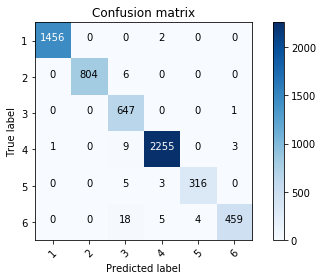

In [15]:
# Compute prediction accuracy on training set
def train_decisionTreeModel2():
    predicted = decisionTree_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(decisionTree_classificator, X_train, Y_train)
    plt.show()

train_decisionTreeModel2()

The accuracy for test database is: 49.828%
Using: 4662 images


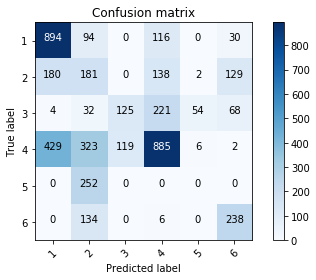

In [16]:
# Compute prediction accuracy on testing set
def test_decisionTreeModel():
    predicted = decisionTree_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(decisionTree_classificator, X_test, Y_test)
    plt.show()

test_decisionTreeModel()

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [17]:
# Define the parameter values that should be searched
depth_range = list(range(1, 30))

# Another parameter besides max_depth that we might vary is the criteria
criterion_options = ['gini', 'entropy']
features_options = ['auto', 'sqrt','log2', None]

# Specify "parameter grid"
param_grid = dict(max_depth=depth_range, criterion=criterion_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(max_depth=depth_range, criterion=criterion_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the DecisionTree classifier
decisionTree = DecisionTreeClassifier()

In [18]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for _ in list(range(20)):
    grid = GridSearchCV(decisionTree, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(decisionTree, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 58.5 s, sys: 5.28 s, total: 1min 3s
Wall time: 22min 36s


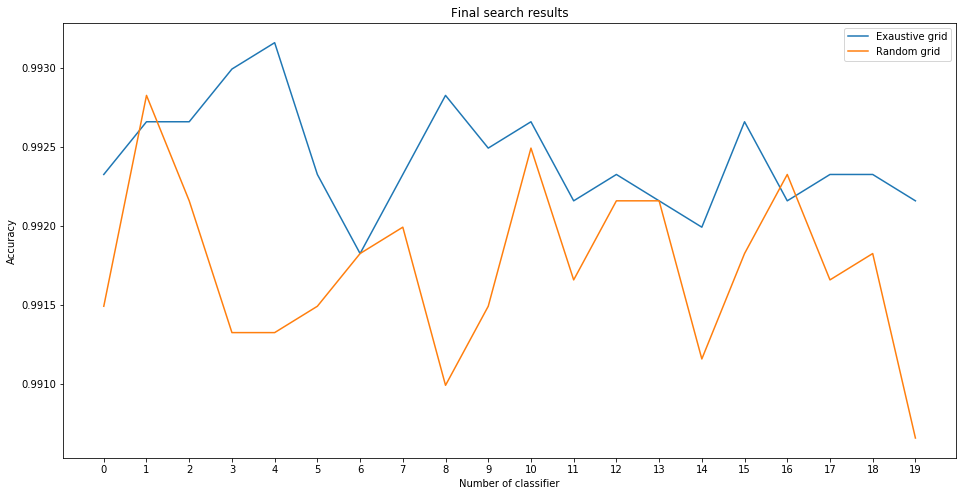

GRID SEARCH RESULTS
The best accuracy is: 99.3159826493%
The parameters is: {'criterion': 'entropy', 'max_depth': 23}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 99.2826159493%
The parameters is: {'criterion': 'entropy', 'max_depth': 19}


In [19]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best DecisionTree classificator

In [20]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [21]:
#Testing this new classificator accuracy with MNIST database 
def validation_database(clf):
    predicted = clf.predict(X_validation)
    
    print("The accuracy for validation database is: " + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(X_train)) + " images to train")
    print("Using: " + str(len(X_test)) + " images to test")
    print("Using: " + str(len(X_validation)) + " images to validate")

    plot_confusion_matrix(clf, X_validation, Y_validation)



In [22]:
best_decisionTree_classificator = train_best_classifier()

The accuracy for validation database is: 54.429%
Using: 5994 images to train
Using: 4662 images to test
Using: 2664 images to validate


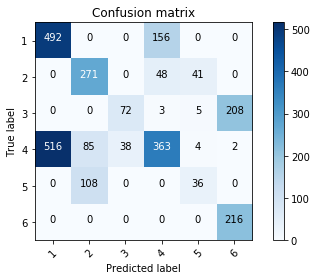

In [23]:
validation_database(best_decisionTree_classificator)

# Features study for decisionTree classifier

In a decisionTree model the feature used to make the classification is very important, so in this part it is made a study on the best feature

In [24]:
#This part displays the table of importance of each feature

bins = np.arange(len(training_set.digits[0].features))
label_list = []
for feature in training_set.digits[0].features:
    label_list.append(feature)

importance = best_decisionTree_classificator.feature_importances_
df = pd.DataFrame({'feature': label_list, 'Level of importance': importance})
df.sort_values(by = ['Level of importance']).reset_index()

,index,Level of importance,feature
0,4,0.001997,active_PC_X
1,5,0.002006,active_PC_Y
2,1,0.004738,mean_grad_D
3,2,0.007177,std_grad_D
4,11,0.013948,mean_PC_X
5,8,0.029333,std_PC_Y
6,0,0.037789,std_grad_M
7,7,0.073017,std_PC_X
8,3,0.111203,var
9,10,0.205470,mean_PC_Y


[Text(0,0,'std_grad_M'),
 Text(0,0,'mean_grad_D'),
 Text(0,0,'std_grad_D'),
 Text(0,0,'var'),
 Text(0,0,'active_PC_X'),
 Text(0,0,'active_PC_Y'),
 Text(0,0,'std'),
 Text(0,0,'std_PC_X'),
 Text(0,0,'std_PC_Y'),
 Text(0,0,'mean_grad_M'),
 Text(0,0,'mean_PC_Y'),
 Text(0,0,'mean_PC_X')]

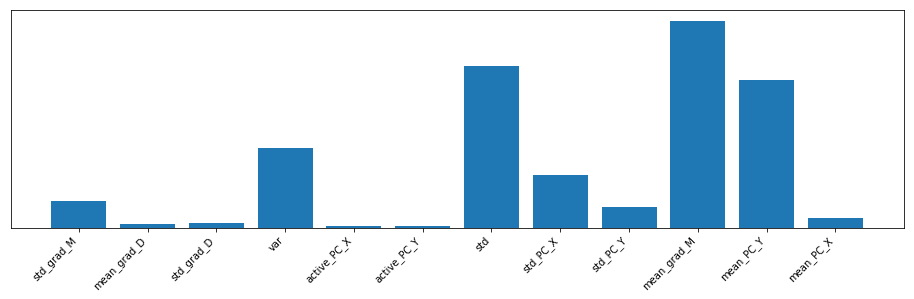

In [25]:
# This part plots a grafic for better visualization

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.bar(bins, importance)
ax.set_xticks(np.arange(len(label_list)))
ax.set_yticks([])
ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
# Display bar graph of feature importances with feature names as labels